# TOBS 2025 Analysis


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('tobs_2025_wide.parquet')
print(f'Loaded: {df.shape[0]} stations × {df.shape[1]} columns')


Loaded: 4706 stations × 367 columns


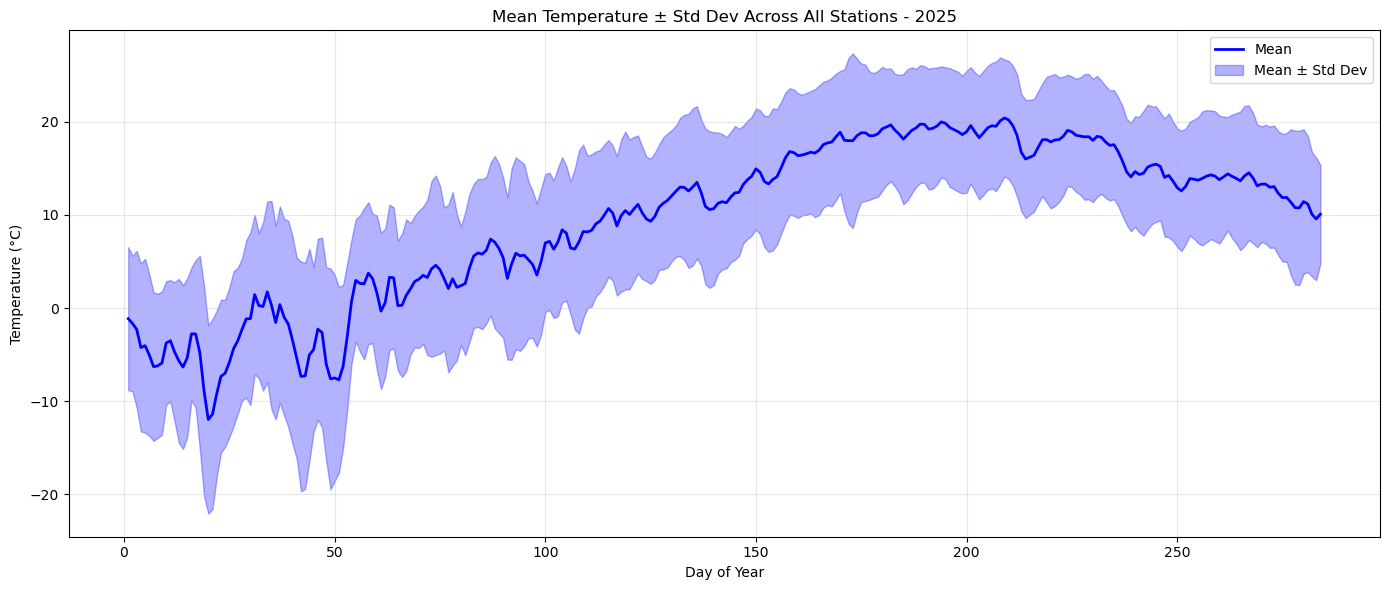

In [8]:
day_cols = [f'day_{d}' for d in range(1, 366)]
means = df[day_cols].mean() / 10  # Convert to °C
stds = df[day_cols].std() / 10
days = range(1, 366)

plt.figure(figsize=(14, 6))
plt.plot(days, means, 'b-', linewidth=2, label='Mean')
plt.fill_between(days, means - stds, means + stds, alpha=0.3, color='blue', label='Mean ± Std Dev')
plt.xlabel('Day of Year')
plt.ylabel('Temperature (°C)')
plt.title('Mean Temperature ± Std Dev Across All Stations - 2025')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Stations: 4706, Days with data: 284


/usr/local/Caskroom/miniforge/base/envs/dask-tutorial/lib/python3.10/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['day_285' 'day_286' 'day_287' 'day_288' 'day_289' 'day_290' 'day_291'
 'day_292' 'day_293' 'day_294' 'day_295' 'day_296' 'day_297' 'day_298'
 'day_299' 'day_300' 'day_301' 'day_302' 'day_303' 'day_304' 'day_305'
 'day_306' 'day_307' 'day_308' 'day_309' 'day_310' 'day_311' 'day_312'
 'day_313' 'day_314' 'day_315' 'day_316' 'day_317' 'day_318' 'day_319'
 'day_320' 'day_321' 'day_322' 'day_323' 'day_324' 'day_325' 'day_326'
 'day_327' 'day_328' 'day_329' 'day_330' 'day_331' 'day_332' 'day_333'
 'day_334' 'day_335' 'day_336' 'day_337' 'day_338' 'day_339' 'day_340'
 'day_341' 'day_342' 'day_343' 'day_344' 'day_345' 'day_346' 'day_347'
 'day_348' 'day_349' 'day_350' 'day_351' 'day_352' 'day_353' 'day_354'
 'day_355' 'day_356' 'day_357' 'day_358' 'day_359' 'day_360' 'day_361'
 'day_362' 'day_363' 'day_364' 'day_365']. At l

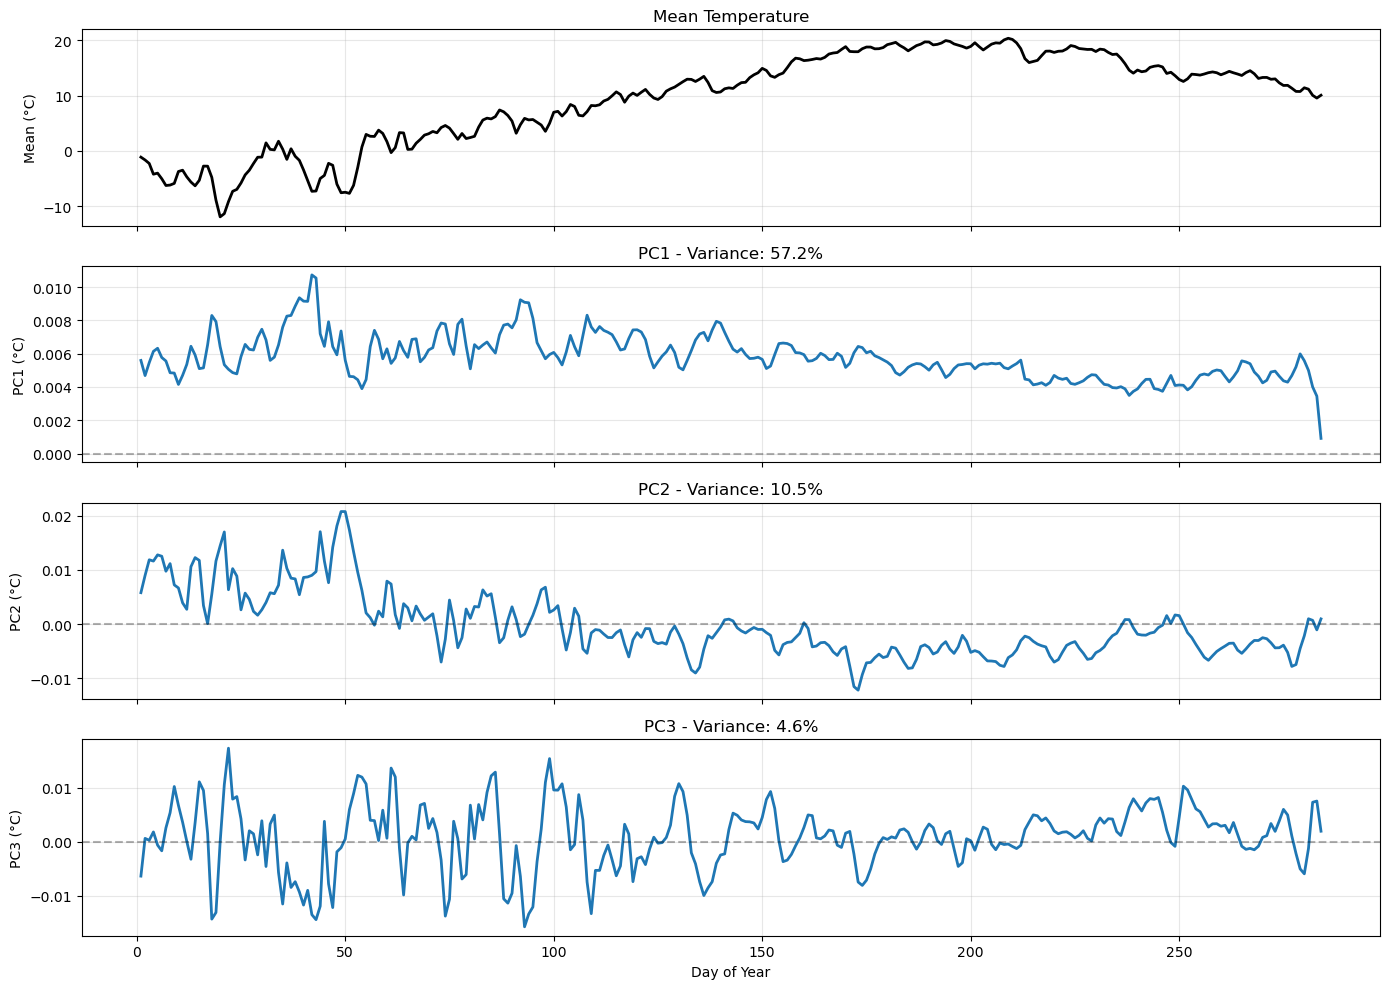


Explained variance ratio: [0.57175764 0.10468601 0.04626744]


In [9]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Prepare data - use imputer to fill missing values
day_cols = [f'day_{d}' for d in range(1, 366)]
imputer = SimpleImputer(strategy='mean')
data = imputer.fit_transform(df[day_cols])
print(f'Stations: {len(data)}, Days with data: {data.shape[1]}')

# Fit PCA
pca = PCA(n_components=3)
pca.fit(data)

# Get mean and eigenvectors
mean_temp = data.mean(axis=0) / 10  # Convert to °C
eigenvectors = pca.components_ / 10  # Convert to °C

# Plot - only for days that have data
n_days = data.shape[1]
days = range(1, n_days + 1)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Mean
axes[0].plot(days, mean_temp, 'k-', linewidth=2)
axes[0].set_ylabel('Mean (°C)')
axes[0].set_title('Mean Temperature')
axes[0].grid(True, alpha=0.3)

# Top 3 eigenvectors
for i in range(3):
    axes[i+1].plot(days, eigenvectors[i], linewidth=2, label=f'PC{i+1}')
    axes[i+1].axhline(0, color='k', linestyle='--', alpha=0.3)
    axes[i+1].set_ylabel(f'PC{i+1} (°C)')
    axes[i+1].set_title(f'PC{i+1} - Variance: {pca.explained_variance_ratio_[i]:.1%}')
    axes[i+1].grid(True, alpha=0.3)

axes[3].set_xlabel('Day of Year')
plt.tight_layout()
plt.show()

print(f'\nExplained variance ratio: {pca.explained_variance_ratio_}')


## Multi-Year Analysis (2020-2025)


In [10]:
import s3fs

# Load TOBS data for years 2020-2025
s3 = s3fs.S3FileSystem(anon=True)
bucket = 'noaa-ghcn-pds'

years = range(2020, 2026)
dfs_all = []

for year in years:
    path = f's3://{bucket}/parquet/by_year/YEAR={year}/ELEMENT=TOBS/'
    df_year = pd.read_parquet(path, storage_options={'anon': True})
    df_year['YEAR'] = year
    dfs_all.append(df_year)
    print(f'{year}: {len(df_year):,} observations')

df_multi = pd.concat(dfs_all, ignore_index=True)
print(f'\nTotal: {len(df_multi):,} observations from {len(years)} years')


2020: 1,694,167 observations
2021: 1,654,798 observations
2022: 1,619,799 observations
2023: 1,596,961 observations
2024: 1,573,441 observations
2025: 1,110,834 observations

Total: 9,250,000 observations from 6 years


In [11]:
# Convert to wide format: station-year rows, day columns
df_multi['DATE_DT'] = pd.to_datetime(df_multi['DATE'], format='%Y%m%d')
df_multi['DAY_OF_YEAR'] = df_multi['DATE_DT'].dt.dayofyear

df_wide_multi = df_multi.pivot_table(
    index=['ID', 'YEAR'],
    columns='DAY_OF_YEAR',
    values='DATA_VALUE',
    aggfunc='first'
).reset_index()

# Rename columns
df_wide_multi.columns = ['station_id', 'year'] + [f'day_{i}' for i in range(1, 367)]
print(f'Wide format: {df_wide_multi.shape[0]:,} station-years × {df_wide_multi.shape[1]} columns')


Wide format: 29,811 station-years × 368 columns


Data: 29,811 station-years × 366 days


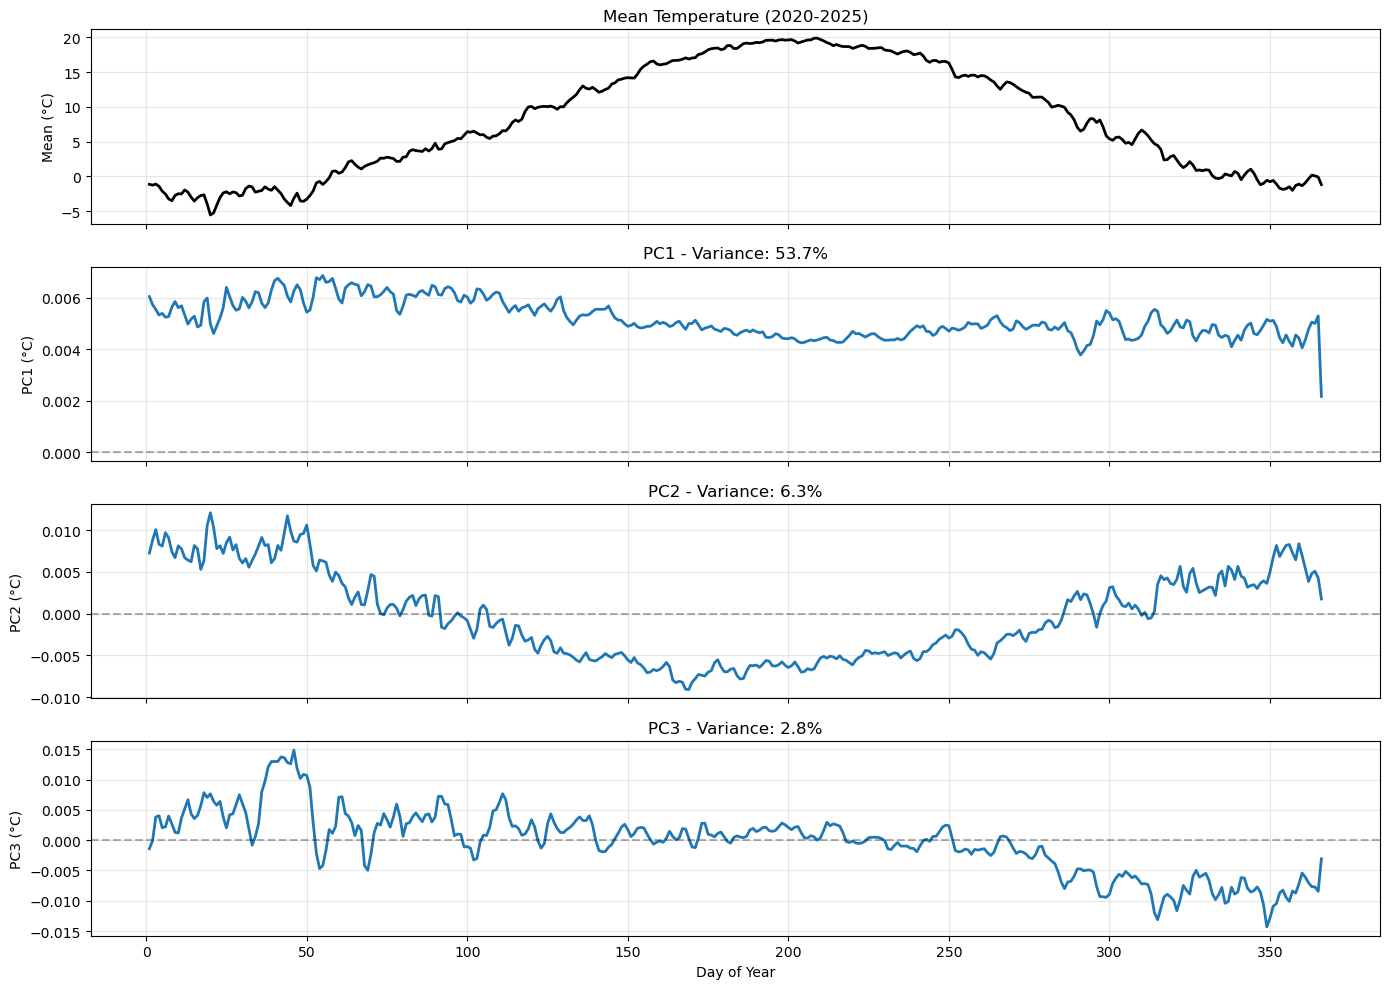


Explained variance: [0.53699749 0.06286997 0.02814081]


In [12]:
# PCA on multi-year data
day_cols = [f'day_{d}' for d in range(1, 367)]
imputer = SimpleImputer(strategy='mean')
data_multi = imputer.fit_transform(df_wide_multi[day_cols])
print(f'Data: {data_multi.shape[0]:,} station-years × {data_multi.shape[1]} days')

pca_multi = PCA(n_components=3)
pca_multi.fit(data_multi)

mean_multi = data_multi.mean(axis=0) / 10
eigenvectors_multi = pca_multi.components_ / 10

# Plot
n_days = data_multi.shape[1]
days = range(1, n_days + 1)
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(days, mean_multi, 'k-', linewidth=2)
axes[0].set_ylabel('Mean (°C)')
axes[0].set_title('Mean Temperature (2020-2025)')
axes[0].grid(True, alpha=0.3)

for i in range(3):
    axes[i+1].plot(days, eigenvectors_multi[i], linewidth=2)
    axes[i+1].axhline(0, color='k', linestyle='--', alpha=0.3)
    axes[i+1].set_ylabel(f'PC{i+1} (°C)')
    axes[i+1].set_title(f'PC{i+1} - Variance: {pca_multi.explained_variance_ratio_[i]:.1%}')
    axes[i+1].grid(True, alpha=0.3)

axes[3].set_xlabel('Day of Year')
plt.tight_layout()
plt.show()

print(f'\nExplained variance: {pca_multi.explained_variance_ratio_}')


Data: 29,811 station-years × 366 days


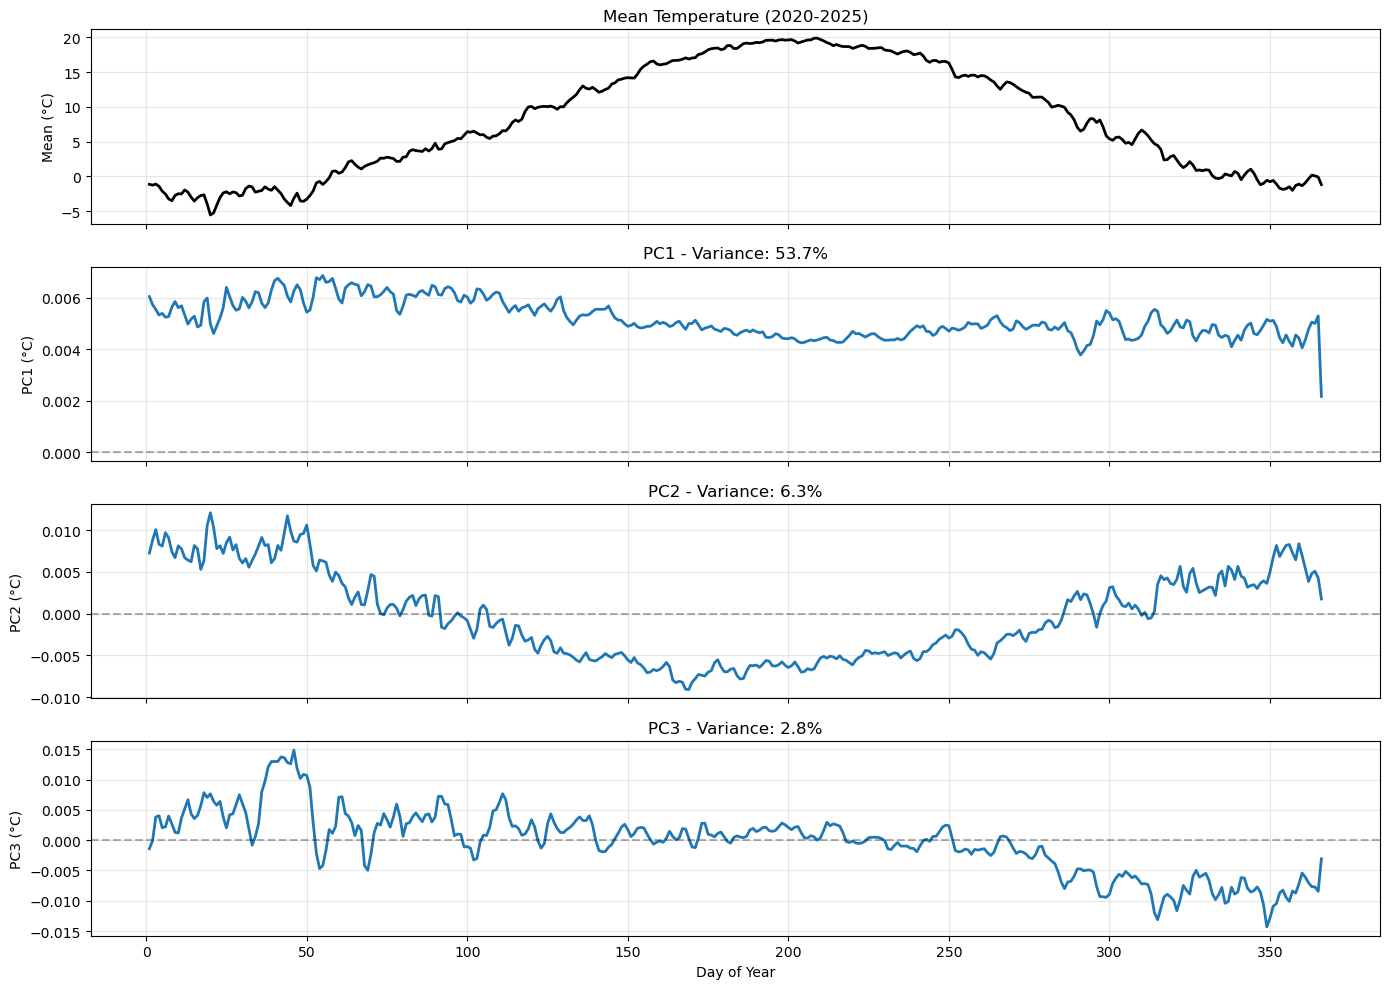


Explained variance: [0.53699749 0.06286997 0.02814081]


In [ ]:
# PCA on multi-year data
day_cols = [f'day_{d}' for d in range(1, 367)]
imputer = SimpleImputer(strategy='mean')
data_multi = imputer.fit_transform(df_wide_multi[day_cols])
print(f'Data: {data_multi.shape[0]:,} station-years × {data_multi.shape[1]} days')

pca_multi = PCA(n_components=3)
pca_multi.fit(data_multi)

mean_multi = data_multi.mean(axis=0) / 10
eigenvectors_multi = pca_multi.components_ / 10

# Plot
n_days = data_multi.shape[1]
days = range(1, n_days + 1)
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(days, mean_multi, 'k-', linewidth=2)
axes[0].set_ylabel('Mean (°C)')
axes[0].set_title('Mean Temperature (2020-2025)')
axes[0].grid(True, alpha=0.3)

for i in range(3):
    axes[i+1].plot(days, eigenvectors_multi[i], linewidth=2)
    axes[i+1].axhline(0, color='k', linestyle='--', alpha=0.3)
    axes[i+1].set_ylabel(f'PC{i+1} (°C)')
    axes[i+1].set_title(f'PC{i+1} - Variance: {pca_multi.explained_variance_ratio_[i]:.1%}')
    axes[i+1].grid(True, alpha=0.3)

axes[3].set_xlabel('Day of Year')
plt.tight_layout()
plt.show()

print(f'\nExplained variance: {pca_multi.explained_variance_ratio_}')
